In [51]:
patient = '708006'

import nibabel as nib
Post_target_Final =  nib.load(patient+'Post_target_Final.nii.gz').get_fdata()
Final_reg_post = nib.load(patient+'Final_reg_post.nii.gz').get_fdata()
or_final = nib.load('data/'+patient+'Final_0000.nii.gz').get_fdata()

Final_reg_pre = nib.load(patient+'Final_reg.nii.gz').get_fdata()
Pre_target_Final = nib.load(patient+'Pre_target_Final.nii.gz').get_fdata()

or_post = nib.load('data/'+patient+'Post_0000.nii.gz').get_fdata()
Pre_target_Post = nib.load(patient+'Pre_target_Post.nii.gz').get_fdata()
Post_reg = nib.load(patient+'Post_reg.nii.gz').get_fdata()




In [6]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt


In [7]:
import torch

In [8]:
d = torch.load('data_dict_bif_angl.pt')

In [9]:
d[patient]

{'bif_(PostTarget_StentMoving)': [[(104, 153), (138, 184), (221, 265)],
  [-0.7194561736161791, -0.4682783379941529, -0.39049585390113256]],
 'bif_(PreTarget_StentMoving)': [[(103, 140), (137, 170), (216, 242)],
  [-2.790864705341589, -2.5232918065611045, -2.456882445382035]],
 'bif_(PreTarget_PostMoving)': [[(37, 23), (151, 139), (184, 172), (261, 243)],
  [-2.1132496119526776,
   -2.246461625556906,
   -2.1902168872270753,
   -2.0304082737626468]]}

In [113]:
def show_images(i):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    axs[0].imshow(Post_target_Final[...,i])
    axs[0].set_title('Target(Post)')

    axs[1].imshow(Final_reg_post[:,:,i])
    axs[1].scatter(centers[i][0], centers[i][1], c='r', s=30)
    axs[1].set_title('Co-registered(Stent)')
    axs[2].imshow(or_final[:,:,i+104])
    axs[2].set_title('Orignal(Stent)')
    plt.show()

# Interactive slider
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, IntSlider
frame_slider = IntSlider(min=0, max=169, step=1, value=0)
interact(show_images, i=frame_slider)


interactive(children=(IntSlider(value=0, description='i', max=169), Output()), _dom_classes=('widget-interact'…

<function __main__.show_images(i)>

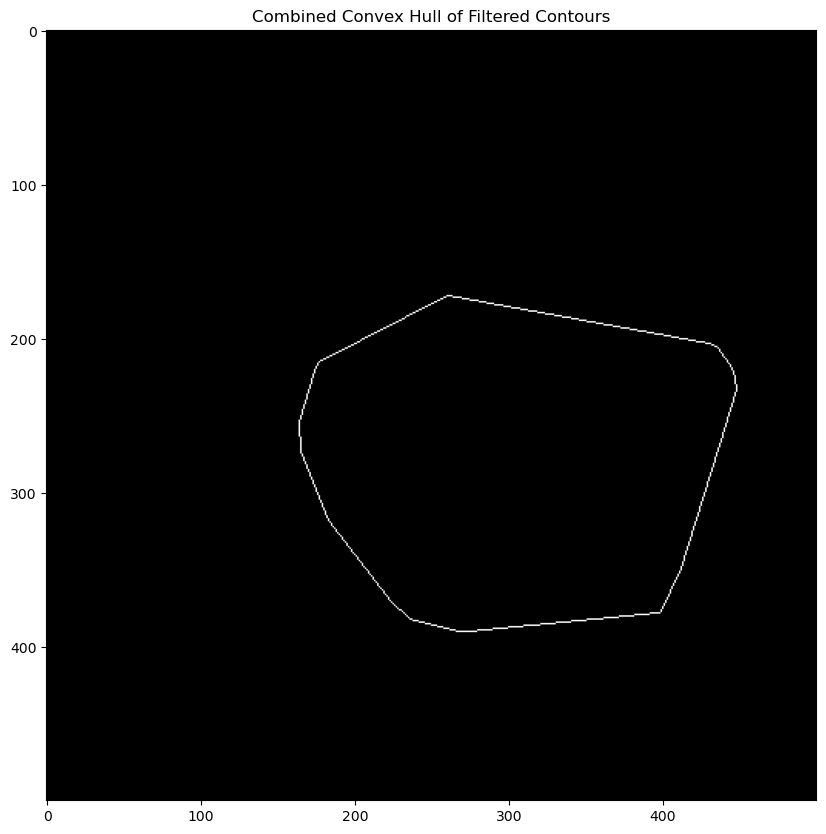

In [85]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the image
l = (Final_reg_post[...,0]/Final_reg_post[...,0].max())*255
image = l.astype(np.uint8)

# Threshold the image to binary
_, binary = cv2.threshold(image, 50, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours by area to exclude the catheter and its shadow
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 500]

# Combine all points from the filtered contours
all_points = np.vstack(filtered_contours)

# Find the convex hull of the combined points
hull = cv2.convexHull(all_points)

# Draw the convex hull on a black background
output = np.zeros_like(image)
output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)  # Ensure output is in correct format

# Draw the convex hull in white color on the output image
cv2.drawContours(output, [hull], -1, (255, 255, 255), 1)

# Convert output back to grayscale for display
output_gray = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)

# Show the convex hull
plt.figure(figsize=(10, 10))
plt.imshow(output_gray, cmap='gray')
plt.title("Combined Convex Hull of Filtered Contours")
plt.show()



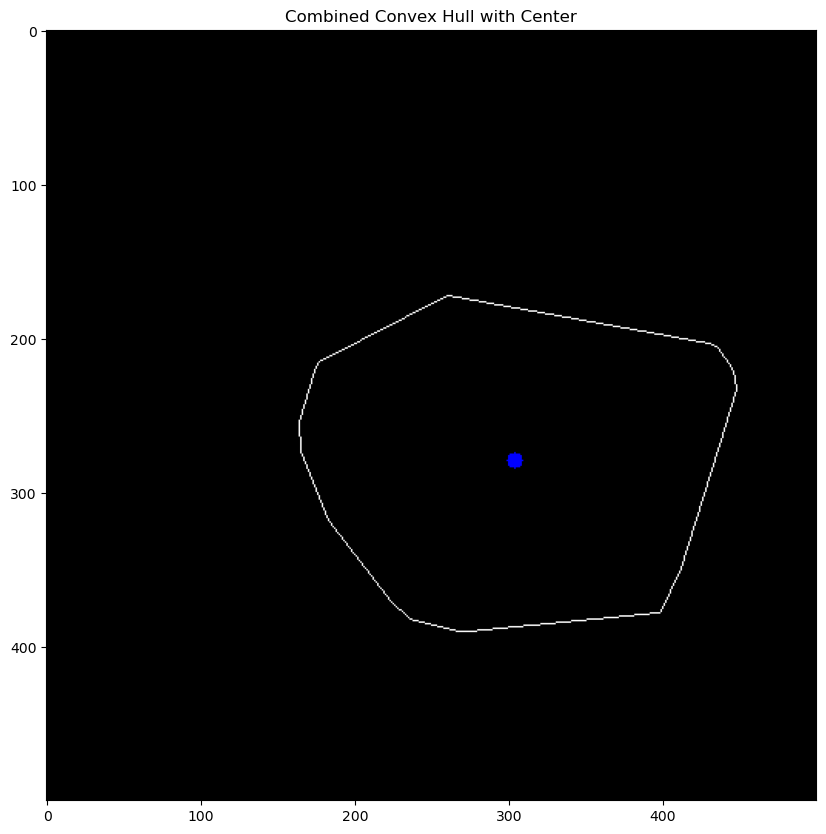

(304, 279)

In [92]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the image
l = (Final_reg_post[...,0]/Final_reg_post[...,0].max())*255
image = l.astype(np.uint8)

# Threshold the image to binary
_, binary = cv2.threshold(image, 50, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours by area to exclude the catheter and its shadow
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 500]

# Combine all points from the filtered contours
all_points = np.vstack(filtered_contours)

# Find the convex hull of the combined points
hull = cv2.convexHull(all_points)

# Draw the convex hull on a black background
output = np.zeros_like(image)
output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)  # Ensure output is in correct format

# Draw the convex hull in white color on the output image
cv2.drawContours(output, [hull], -1, (255, 255, 255), 1)

# Convert output back to grayscale for display
output_gray = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)

# Calculate the moments of the convex hull
moments = cv2.moments(hull)

# Calculate the centroid (center) of the convex hull
if moments["m00"] != 0:
    cX = int(moments["m10"] / moments["m00"])
    cY = int(moments["m01"] / moments["m00"])
else:
    cX, cY = 0, 0

# Draw the center on the output image
cv2.circle(output, (cX, cY), 5, (0, 0, 255), -1)  # Red color for the center

# Show the convex hull with center
plt.figure(figsize=(10, 10))
plt.imshow(output)
plt.title("Combined Convex Hull with Center")
plt.show()

# Print the center coordinates
(cX, cY)


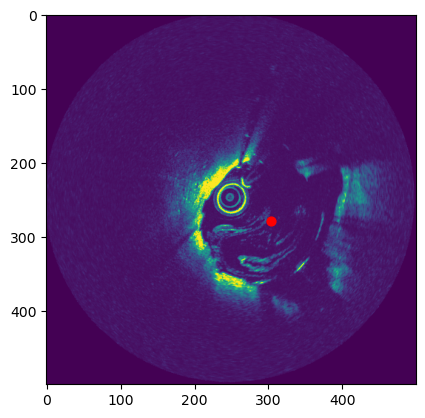

In [93]:
#plot l and center (304, 279)
plt.imshow(l)
plt.scatter(304, 279, c='r', s=40)



In [115]:
torch.tensor(l)

255.0

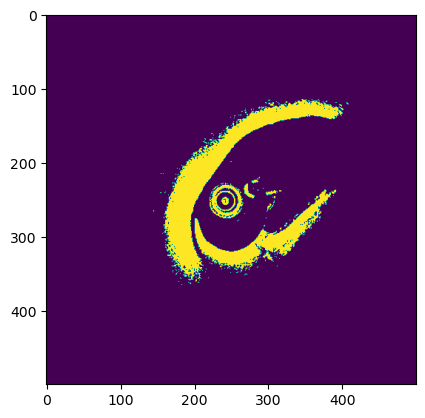

In [99]:
plt.imshow(binary)

In [111]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
# Assuming Final_reg_post is already defined

def center_estimate(Final_reg_post):
    #Final_reg_post shape is  (H, W, D)
    centers = []

    for i in range(Final_reg_post.shape[2]):
        # Load the image
        l = (Final_reg_post[..., i] / Final_reg_post[..., i].max()) * 255
        image = l.astype(np.uint8)

        # Threshold the image to binary
        _, binary = cv2.threshold(image, 50, 255, cv2.THRESH_BINARY)

        # Find contours
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Filter contours by area to exclude the catheter and its shadow
        filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 500]

        if filtered_contours:
            # Combine all points from the filtered contours
            all_points = np.vstack(filtered_contours)

            # Find the convex hull of the combined points
            hull = cv2.convexHull(all_points)

            # Calculate the moments of the convex hull
            moments = cv2.moments(hull)

            # Calculate the centroid (center) of the convex hull
            if moments["m00"] != 0:
                cX = int(moments["m10"] / moments["m00"])
                cY = int(moments["m01"] / moments["m00"])
            else:
                cX, cY = 0, 0

            centers.append((cX, cY))
            """
            # Draw the convex hull on a black background
            output = np.zeros_like(image)
            output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)  # Ensure output is in correct format
            
            # Draw the convex hull in white color on the output image
            cv2.drawContours(output, [hull], -1, (255, 255, 255), 1)

            # Draw the center on the output image
            cv2.circle(output, (cX, cY), 5, (0, 0, 255), -1)  # Red color for the center

            # Show the convex hull with center
            plt.figure(figsize=(10, 10))
            plt.imshow(output)
            plt.title(f"Combined Convex Hull with Center for Channel {i}")
            plt.show()
            """


        else:
            centers.append((None, None))  # If no contours are found
    # Convert centers to numpy arrays for easier processing
    centers = np.array([c for c in centers if c[0] is not None and c[1] is not None])

    # Ensure there are enough points to apply the filter
    if len(centers) > 31:
        # Smooth the center coordinates
        centers = np.copy(centers)

        
        for dim in range(2):  # For both x and y dimensions
            centers[:, dim] = savgol_filter(centers[:, dim], 32, 2)
    # Print all the centers
    return  centers


In [112]:
centers = center_estimate(Final_reg_post)

In [110]:
centers

In [22]:
def show_images(i):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    axs[0].imshow(Pre_target_Final[...,i])
    axs[0].set_title('Target(Pre)')

    axs[1].imshow(Final_reg_pre[:,:,i])
    axs[1].set_title('Co-registered(Stent)')
    axs[2].imshow(or_final[:,:,i+103])
    axs[2].set_title('Orignal(Post)')
    plt.show()

# Interactive slider
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, IntSlider
frame_slider = IntSlider(min=0, max=Pre_target_Final.shape[1]-1, step=1, value=0)
interact(show_images, i=frame_slider)

interactive(children=(IntSlider(value=0, description='i', max=499), Output()), _dom_classes=('widget-interact'…

<function __main__.show_images(i)>

In [20]:
def show_images(i):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    axs[0].imshow(Pre_target_Post[...,i])
    axs[0].set_title('Target(Pre)')

    axs[1].imshow(Post_reg[:,:,i])
    axs[1].set_title('Co-registered(Post)')
    axs[2].imshow(or_post[:,:,i+37])
    axs[2].set_title('Orignal(Pre)')
    plt.show()

# Interactive slider
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, IntSlider
frame_slider = IntSlider(min=0, max=Pre_target_Final.shape[1]-1, step=1, value=0)
interact(show_images, i=frame_slider)

interactive(children=(IntSlider(value=0, description='i', max=499), Output()), _dom_classes=('widget-interact'…

<function __main__.show_images(i)>